In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import qmc
import pymc as pm
import math
from matplotlib.markers import MarkerStyle
from scipy.stats import norm
import pytensor.tensor as pt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## READ IN DATA

In [2]:
svm_df = pd.read_csv('./data/svm.csv',header=None)
lda_df = pd.read_csv('./data/lda.csv', header=None)

In [3]:
svm_df.head()

,0,1,2,3,4
0,600.0,0.5,0.0100,0.27620,191.980
1,900.0,0.8,0.1000,0.27420,99.976
2,2000.0,5.0,0.1000,0.27910,114.410
3,5000.0,1.0,0.0001,0.25770,748.726
4,1.0,5.0,0.0001,0.28714,1048.862


In [4]:
lda_df.head()

,0,1,2,3,4
0,1.0,4.0,16.0,2014.255351,36393.19
1,0.9,1024.0,4096.0,1680.540179,36419.51
2,0.6,1024.0,4096.0,1328.191297,24219.85
3,0.6,16.0,4.0,2859.440420,18862.01
4,0.7,1.0,4096.0,1313.263743,11218.42


## VISUALIZE DATA

In [5]:
def goldstein_price(x,y):
      return (1+(x+y+1)**2*(19-14*x+3*x**2-14*y+6*x*y+3*y**2))*(30+(2*x-3*y)**2*(18-32*x+12*x**2+48*y-36*x*y+27*y**2))  

#### Make a heatmap of the value of the Goldstein–Price function over the domain X= [−2,2] × [−2,2] using a dense grid of values, with 1000 values per dimension, forming a 1000 ×1000 image.

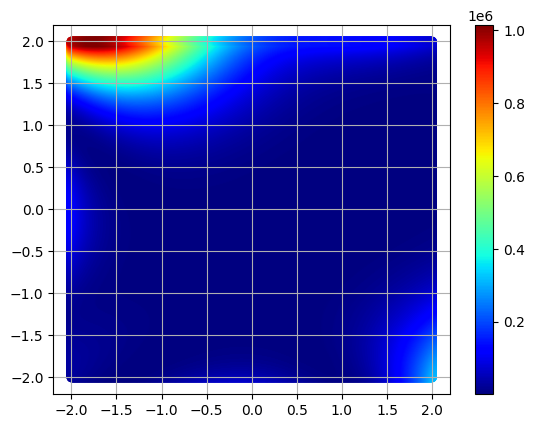

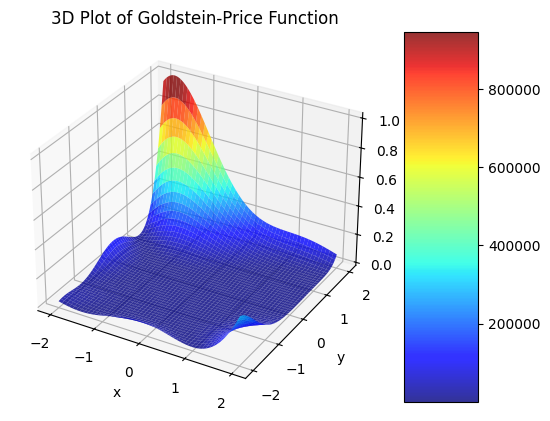

In [6]:
x = np.linspace(-2,2,1000)
y = np.linspace(-2,2,1000)
x, y = np.meshgrid(x, y)
Z = goldstein_price(x,y)


plt.scatter(x, y, c=Z, cmap='jet',vmin=Z.min(), vmax=Z.max())
plt.colorbar()
plt.grid()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, Z, cmap='jet', alpha = 0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('3D Plot of Goldstein-Price Function')
fig.colorbar(surf, aspect=5)
plt.show()

#### Describe the behavior of the function. Does it appear stationary? (That is, does the behavior of the function appear to be relatively constant throughout the domain?)

It appears to remain relatively stationary throughout the domain except for a large spike near (-2,2).

#### Can you find a transformation of the data that makes it more stationary?

##### MEAN 0 STD 1

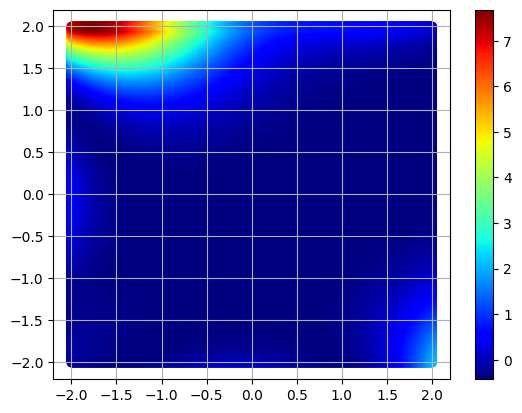

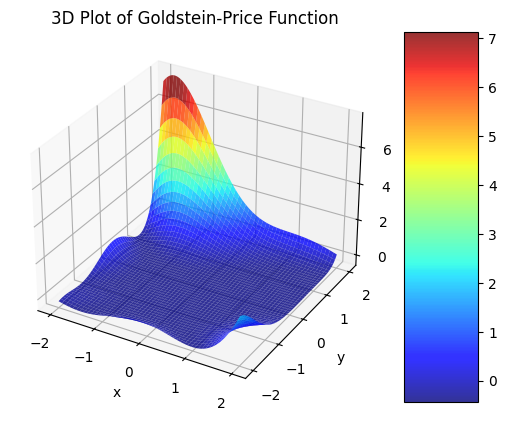

In [7]:
x = np.linspace(-2,2,1000)
y = np.linspace(-2,2,1000)
x, y = np.meshgrid(x, y)
Z = goldstein_price(x,y)

#Mean 0, STD 1
Z = (Z  - Z.mean()) / Z.std()


#2D
plt.scatter(x, y, c=Z, cmap='jet',vmin=Z.min(), vmax=Z.max())
plt.colorbar()
plt.grid()
plt.show()

#3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, Z, cmap='jet', alpha = 0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('3D Plot of Goldstein-Price Function')
fig.colorbar(surf, aspect=5)
plt.show()

##### NORMALIZATION

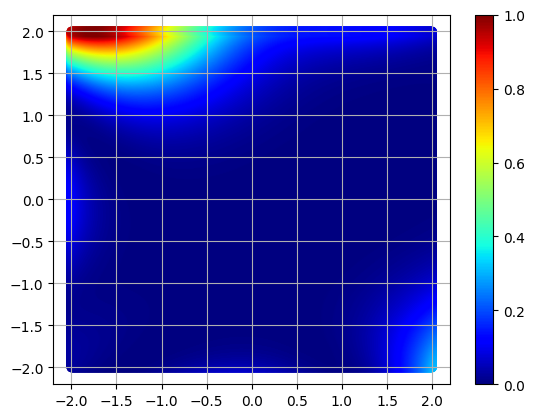

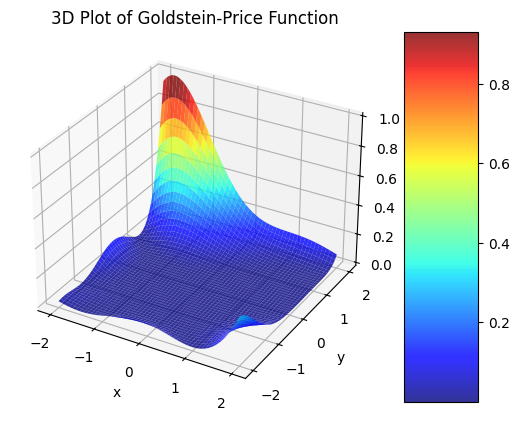

In [8]:
x = np.linspace(-2,2,1000)
y = np.linspace(-2,2,1000)
x, y = np.meshgrid(x, y)
Z = goldstein_price(x,y)

Z = (Z  - Z.min()) / (Z.max()- Z.min())


#2D
plt.scatter(x, y, c=Z, cmap='jet',vmin=Z.min(), vmax=Z.max())
plt.colorbar()
plt.grid()
plt.show()

#3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, Z, cmap='jet', alpha = 0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('3D Plot of Goldstein-Price Function')
fig.colorbar(surf, aspect=5)
plt.show()

##### LOGARITHMIC

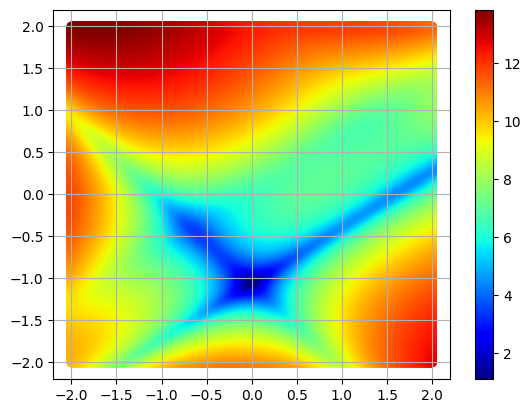

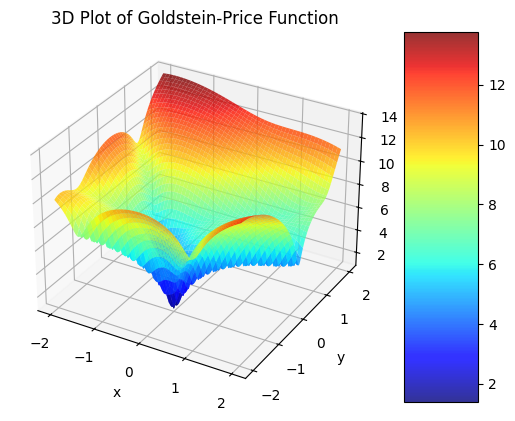

In [9]:
x = np.linspace(-2,2,1000)
y = np.linspace(-2,2,1000)
x, y = np.meshgrid(x, y)
Z = goldstein_price(x,y)

Z = np.log(Z)


#2D
plt.scatter(x, y, c=Z, cmap='jet',vmin=Z.min(), vmax=Z.max())
plt.colorbar()
plt.grid()
plt.show()

#3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, Z, cmap='jet', alpha = 0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('3D Plot of Goldstein-Price Function')
fig.colorbar(surf, aspect=5)
plt.show()

#### Make a kernel density estimate of the distribution of the values for the lda and svm bench- marks. Interpret the distributions.

##### SVM

<Figure size 640x480 with 0 Axes>

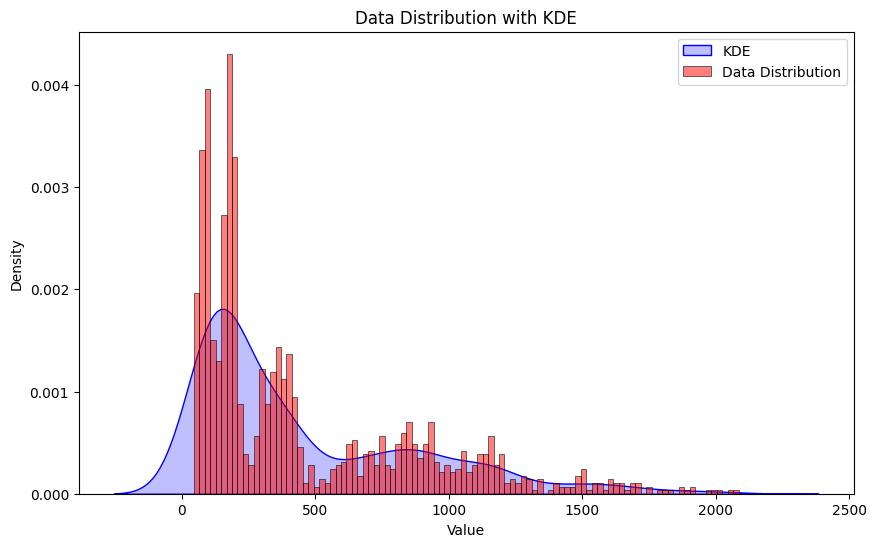

In [10]:
plt.figure("HISTOGRAM_SVM")


data = svm_df[4].to_numpy()

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue', label='KDE')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


#### Interpret the distributions
The distribution appears to be heavily right-skewed.

##### IDA

<Figure size 640x480 with 0 Axes>

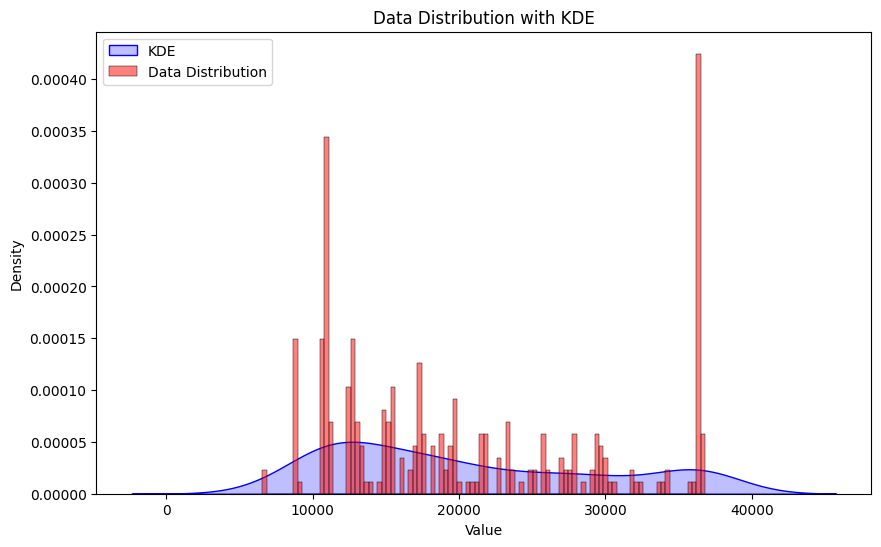

In [11]:
plt.figure("HISTOGRAM_LDA")


data = lda_df[4].to_numpy()

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue', label='KDE')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


#### Interpret the distributions
The distribution appears to be bimodal with a large peak around 10000 and a smaller peak around 38000.

#### Again, can you find a transformation that makes the performance better behaved?

##### MEAN 0, STD 1

###### SVM

<Figure size 640x480 with 0 Axes>

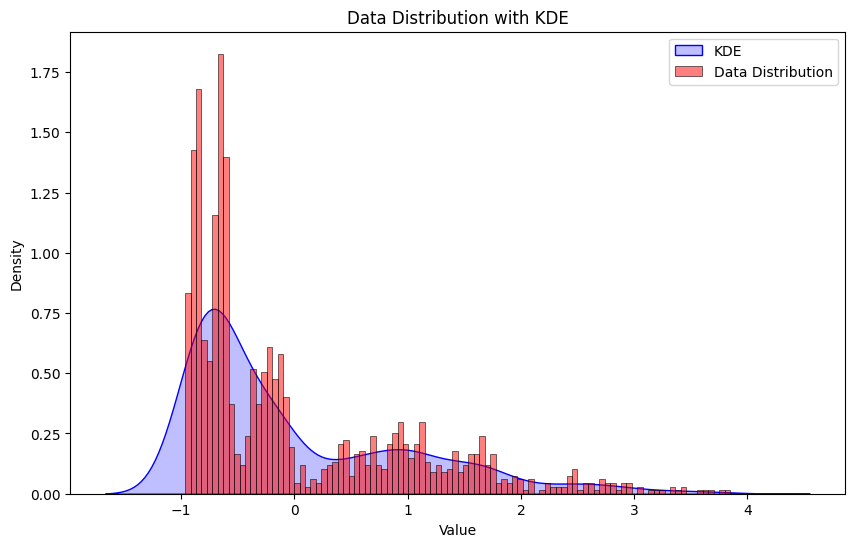

In [12]:
plt.figure("HISTOGRAM_SVM")


data = svm_df[4].to_numpy()

data = (data - data.mean()) / data.std()

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue', label='KDE')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


###### IDA

<Figure size 640x480 with 0 Axes>

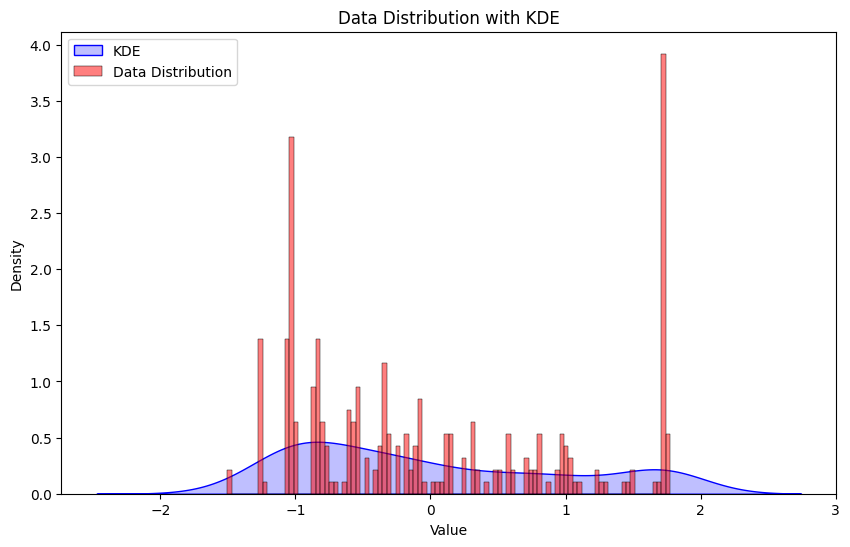

In [13]:
plt.figure("HISTOGRAM_LDA")


data = lda_df[4].to_numpy()
data = (data - data.mean()) / data.std()

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue', label='KDE')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


##### Normalize

###### SVM

<Figure size 640x480 with 0 Axes>

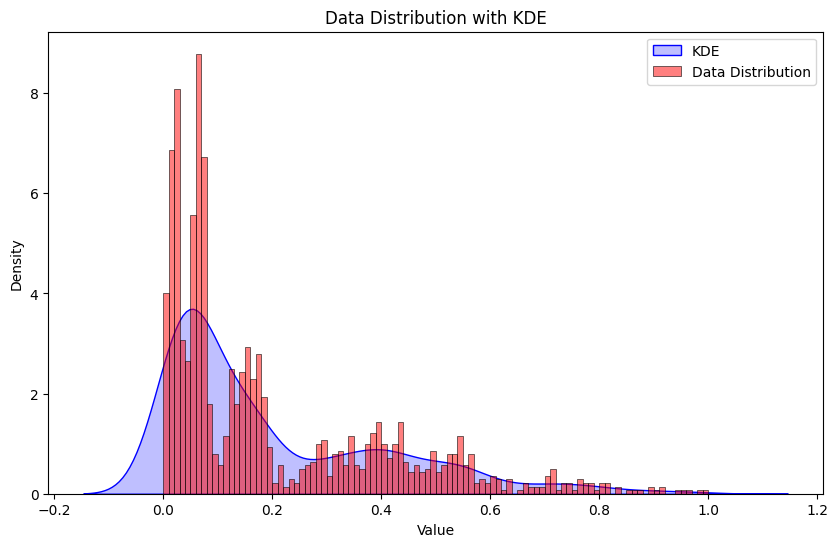

In [14]:
plt.figure("HISTOGRAM_SVM")


data = svm_df[4].to_numpy()

data = (data - data.min()) / (data.max() - data.min())

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue', label='KDE')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


###### IDA

<Figure size 640x480 with 0 Axes>

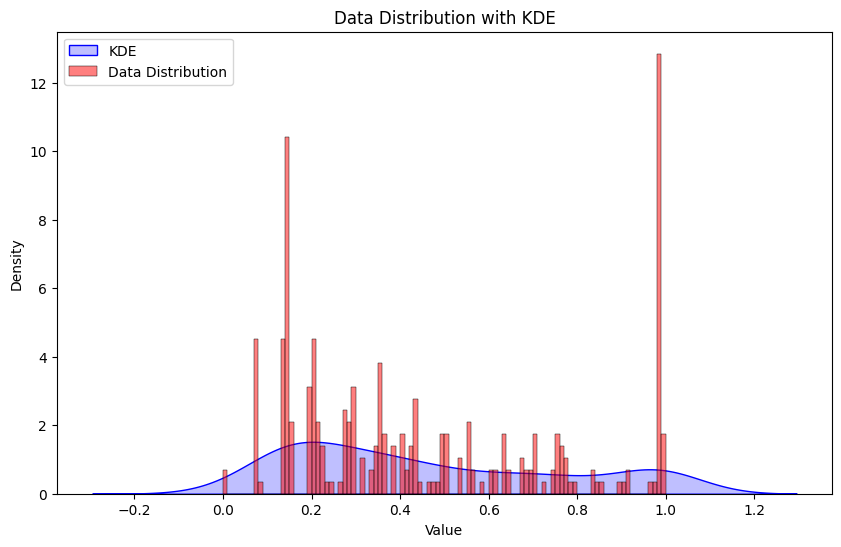

In [15]:
plt.figure("HISTOGRAM_LDA")


data = lda_df[4].to_numpy()
data = (data - data.min()) / (data.max() - data.min())

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue', label='KDE')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


##### Log Scale

###### SVM

<Figure size 640x480 with 0 Axes>

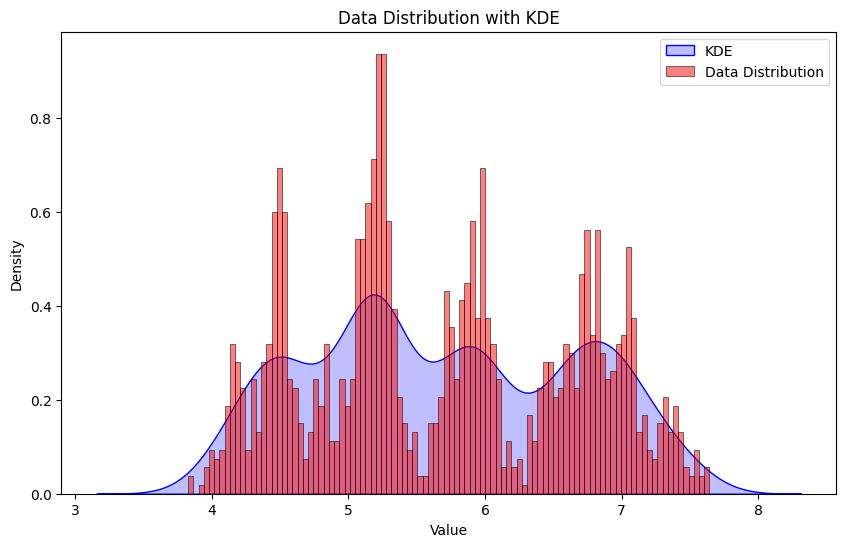

In [16]:
plt.figure("HISTOGRAM_SVM")


data = svm_df[4].to_numpy()
data = np.log(data + 1)

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue', label='KDE')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


###### IDA

<Figure size 640x480 with 0 Axes>

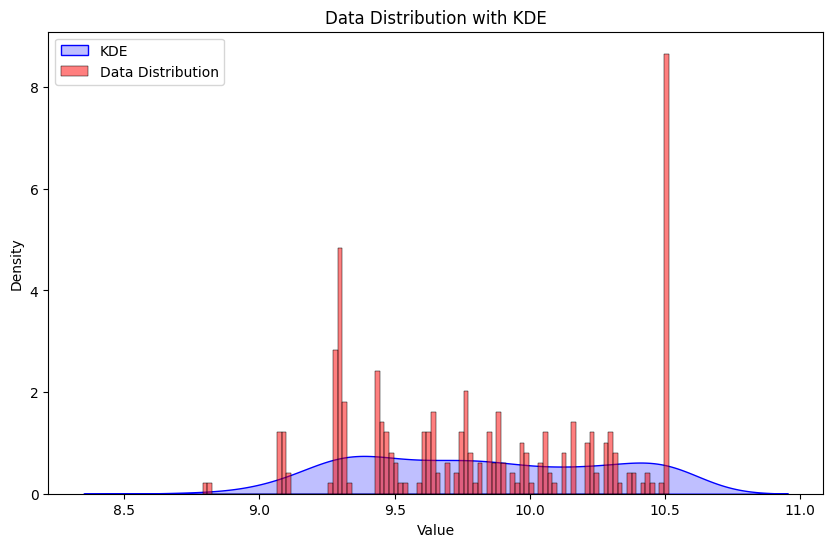

In [17]:
plt.figure("HISTOGRAM_LDA")


data = lda_df[4].to_numpy()
data = np.log(data + 1)

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue', label='KDE')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


## Model fitting

In [18]:
domain = [-2, 2]
sampler = qmc.Sobol(d=2, scramble=True)
samples = sampler.random_base2(m=5)
scaled_samples = domain[0] + (domain[1] - domain[0]) * samples
x,y = scaled_samples[:,0], scaled_samples[:,1]
X_train = scaled_samples

X = np.linspace(0, len(X_train)-1, len(X_train))
Y_train = goldstein_price(x,y)

x1_range = np.linspace(-2, 2, 100)
x2_range = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_pred = np.column_stack([X1.ravel(), X2.ravel()])
Y_true = goldstein_price(X1,X2)

### WITHOUT LOG SCALE

#### Select a set of 32 training points for the Goldstein–Price function in the domain X= [−2,2] ×[−2,2] using a Sobol sequence. This is a so-called low-discrepancy sequence that produces “quasirandom” points that fill the space relatively evenly; see the Wikipedia article for more information, and note that this should be built into most scientific software. Measure the function at these locations to form a dataset D.

#### Fit a Gaussian process model to the data using a constant mean and a squared exponential covariance. As the output of a deterministic computer program, there is no “noise” in our observations, so we should fix the standard deviation of the noise to a small value such as 0.001. This is possible in most gp software packages. Maximize the marginal likelihood of the data as a function of the hyperparameters: constant mean value and the length scale and output scale of the covariance function.

The hyperparamters output below make sense

In [ ]:
with pm.Model() as model:
      
      mean_const = pm.Normal("mean_const", mu=0, sigma=10)  # Constant mean
      length_scale = pm.Gamma("length_scale", alpha=2, beta=1)  # Length scale
      output_scale = pm.HalfCauchy("output_scale", beta=2)  # Output scale
      
      cov_func = output_scale**2 * pm.gp.cov.ExpQuad(2, ls=length_scale)
      gp = pm.gp.Marginal(mean_func=pm.gp.mean.Constant(mean_const), cov_func=cov_func)
      sigma_n = 0.001
      y_dist = gp.marginal_likelihood("y_dist", X=X_train, y=Y_train, sigma=sigma_n)

      # Step 4: Sample from the posterior for predictions
      trace = pm.sample(1000, tune=1000, return_inferencedata=True)
      pm.compute_log_likelihood(trace)

x1_range = np.linspace(-2, 2, 100)
x2_range = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_pred = np.column_stack([X1.ravel(), X2.ravel()])
Y_true = goldstein_price(X1,X2)

with model:
    mu, var = gp.predict(X_pred, point=trace.posterior.mean(), diag=True)
    std = np.sqrt(var)
print(f"Mu: {trace.posterior.mean_const.mean()}")
print(f"Length Scale: {trace.posterior.length_scale.mean()}")
print(f"Output Scale: {trace.posterior.output_scale.mean()}")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_const, length_scale, output_scale]


Output()

#### Make a heatmap of the Gaussian process posterior mean as you did of the function. Compare the predicted values with the true values. Do you see systematic errors?

I do not see systematic errors, the general shape of the heat maps and 3d plots look the same for the real goldstein-price function with the exeptions being the unstable parts where there is not a lot of data sampled. However, those parts have a larger STD with shows the uncertinaty of the estimation there. 

##### MEAN

/var/folders/2v/9rjk2f_n3pgd38k9vyj_8_tw0000gn/T/ipykernel_12298/1443281933.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_train[:,0], X_train[:,1],Y_train, cmap='jet' ,label = 'data points')


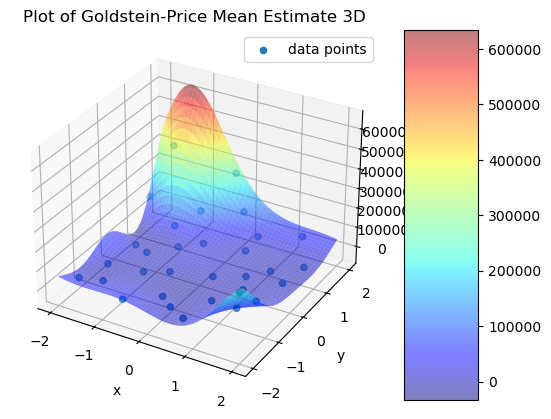

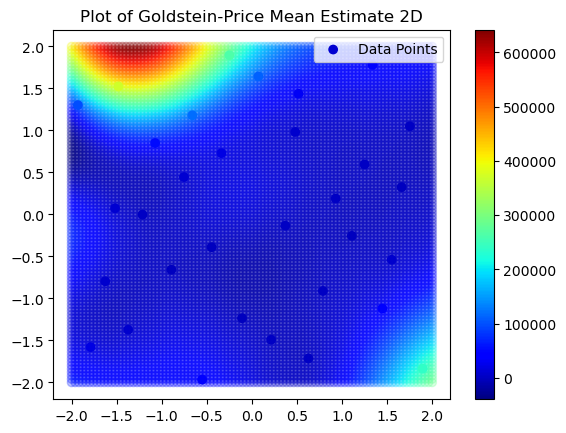

In [189]:



##MEAN
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X1, X2, mu.reshape((len(X1), len(X2))), cmap='jet', alpha = 0.5)
ax.scatter(X_train[:,0], X_train[:,1],Y_train, cmap='jet' ,label = 'data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.title('Plot of Goldstein-Price Mean Estimate 3D')
fig.colorbar(surf, aspect=5)
plt.show()


fig = plt.figure()
plt.title('Plot of Goldstein-Price Mean Estimate 2D')
plt.scatter(X1, X2, c=mu, cmap='jet',vmin=mu.min(), vmax=mu.max(), alpha = 0.25)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap='jet',vmin=mu.min(), vmax=mu.max(), label = 'Data Points')
plt.colorbar()
plt.legend()
plt.show()


###### Comparision to True Values 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


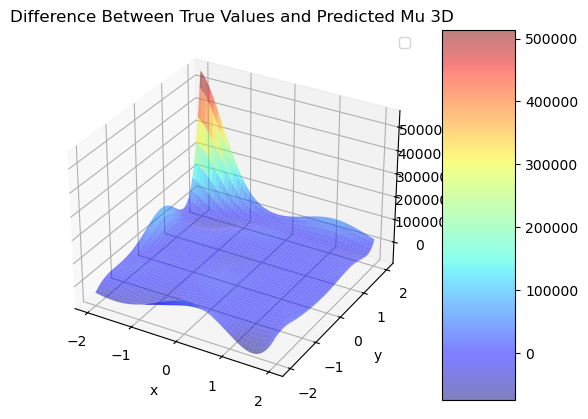

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


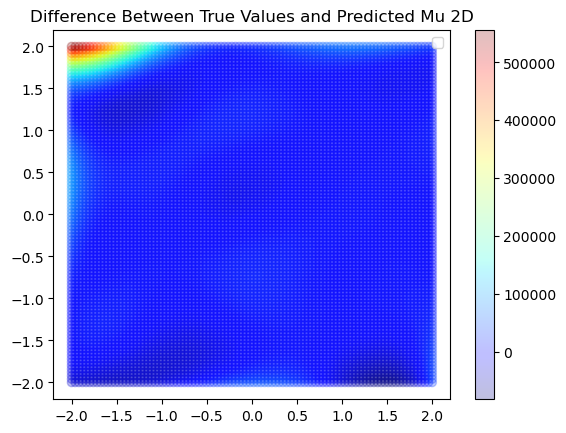

In [190]:
##MEAN

data = Y_true - mu.reshape((len(X1), len(X2)))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X1, X2, data, cmap='jet', alpha = 0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.title('Difference Between True Values and Predicted Mu 3D')
fig.colorbar(surf, aspect=5)
plt.show()


fig = plt.figure()
plt.title('Difference Between True Values and Predicted Mu 2D')
plt.scatter(X1, X2, c=data, cmap='jet',vmin=data.min(), vmax=data.max(), alpha = 0.25)
plt.colorbar()
plt.legend()
plt.show()


##### STD

These STD values make sense. They are 0 where we have a data point and know the value with certainty. Additonally, they are higher where they are is more vairance in the function and where we have less data points sampled

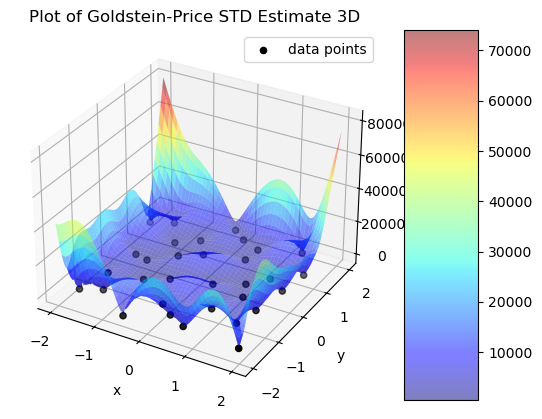

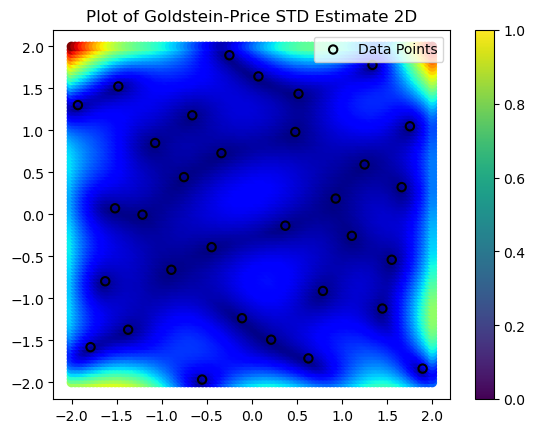

In [191]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X1, X2, std.reshape((len(X1), len(X2))), cmap='jet', alpha = 0.5)
ax.scatter(X_train[:,0], X_train[:,1],0, color = 'black', label = 'data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.title('Plot of Goldstein-Price STD Estimate 3D')
fig.colorbar(surf, aspect=5)
plt.show()


fig2 = plt.figure()
plt.title('Plot of Goldstein-Price STD Estimate 2D')
plt.scatter(X1, X2, c=std, cmap='jet',vmin=std.min(), vmax=std.max(), alpha = 1)
plt.scatter(X_train[:,0], X_train[:,1], color='black', label = 'Data Points', marker= MarkerStyle('o', fillstyle = 'none')  )
plt.colorbar()
plt.legend()
plt.show()


#### Z Scores 

This is good as it looks like a normal distribution

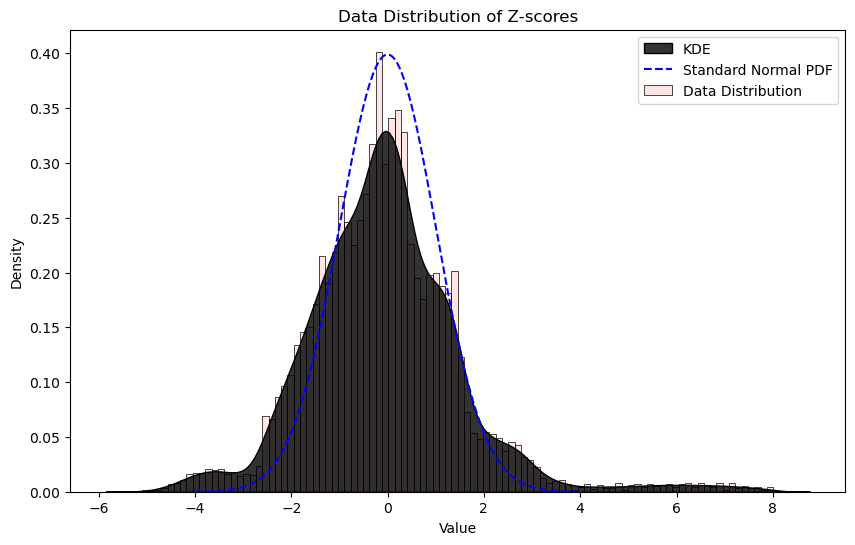

Z-Score Mean: -0.06, Standard Deviation: 1.61


In [192]:
z_scores = ((Y_true - mu.reshape((len(X1), len(X2))))/ std.reshape((len(X1), len(X2)))).reshape(-1)

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution of Z-scores")

# Plot the histogram of the data (distribution)
x_plot = np.linspace(-4, 4, 500)
sns.histplot(z_scores, kde=False, bins=100, color='red', stat='density', alpha=0.1, label="Data Distribution")
sns.kdeplot(z_scores, fill=True, color='black', label='KDE',alpha=0.8)
plt.plot(x_plot, norm.pdf(x_plot), label="Standard Normal PDF", color="blue", linestyle="--")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()



z_mean = np.mean(z_scores)
z_std = np.std(z_scores)
print(f"Z-Score Mean: {z_mean:.2f}, Standard Deviation: {z_std:.2f}")


### WITH LOG SCALE

#### Fit a Gaussian process model to the data using a constant mean and a squared exponential covariance. As the output of a deterministic computer program, there is no “noise” in our observations, so we should fix the standard deviation of the noise to a small value such as 0.001. This is possible in most gp software packages. Maximize the marginal likelihood of the data as a function of the hyperparameters: constant mean value and the length scale and output scale of the covariance function.

The hyperparamters output below make sense

In [ ]:
Y_train_log = np.log(Y_train)
Y_true_log = np.log(Y_true)

In [ ]:
with pm.Model() as model:
      
      mean_const = pm.Normal("mean_const", mu=0, sigma=10)  # Constant mean
      length_scale = pm.Gamma("length_scale", alpha=2, beta=1)  # Length scale
      output_scale = pm.HalfCauchy("output_scale", beta=2)  # Output scale

      
      cov_func = output_scale**2 * pm.gp.cov.ExpQuad(2, ls=length_scale)
      
      gp = pm.gp.Marginal(mean_func=pm.gp.mean.Constant(mean_const), cov_func=cov_func)
      sigma_n = 0.001
      y_dist = gp.marginal_likelihood("y_dist", X=X_train, y=Y_train_log, sigma=sigma_n)


      # Step 4: Sample from the posterior for predictions
      trace = pm.sample(1000, tune=1000, return_inferencedata=True)



with model:
    mu, var = gp.predict(X_pred, point=trace.posterior.mean(), diag=True)
    std = np.sqrt(var)
print(f"Mu: {trace.posterior.mean_const.mean()}")
print(f"Length Scale: {trace.posterior.length_scale.mean()}")
print(f"Output Scale: {trace.posterior.output_scale.mean()}")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_const, length_scale, output_scale]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Mu: <xarray.DataArray 'mean_const' ()>
array(9.43238833)
Length Scale: <xarray.DataArray 'length_scale' ()>
array(0.53315833)
Output Scale: <xarray.DataArray 'output_scale' ()>
array(2.429068)


#### Make a heatmap of the Gaussian process posterior mean as you did of the function. Compare the predicted values with the true values. Do you see systematic errors?

I do not see systematic errors, the general shape of the heat maps and 3d plots look the same for the real goldstein-price function with the exeptions being the unstable parts where there is not a lot of data sampled. However, those parts have a larger STD with shows the uncertinaty of the estimation there. 

##### MEAN

/var/folders/2v/9rjk2f_n3pgd38k9vyj_8_tw0000gn/T/ipykernel_12298/1443281933.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_train[:,0], X_train[:,1],Y_train, cmap='jet' ,label = 'data points')


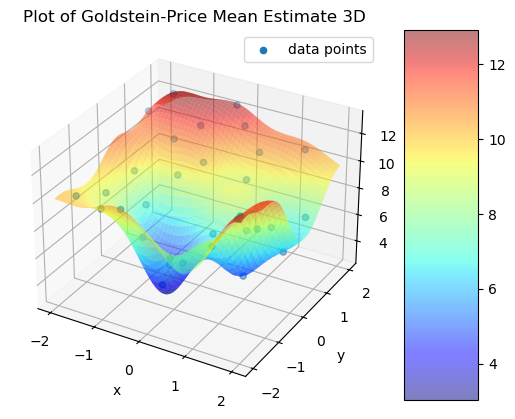

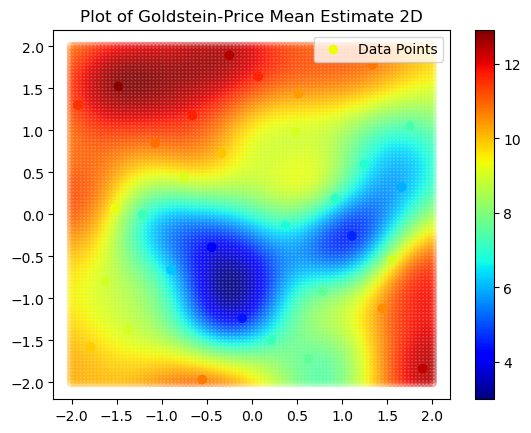

In [ ]:



##MEAN
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X1, X2, mu.reshape((len(X1), len(X2))), cmap='jet', alpha = 0.5)
ax.scatter(X_train[:,0], X_train[:,1],Y_train_log, cmap='jet' ,label = 'data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.title('Plot of Goldstein-Price Mean Estimate 3D')
fig.colorbar(surf, aspect=5)
plt.show()


fig = plt.figure()
plt.title('Plot of Goldstein-Price Mean Estimate 2D')
plt.scatter(X1, X2, c=mu, cmap='jet',vmin=mu.min(), vmax=mu.max(), alpha = 0.25)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train_log, cmap='jet',vmin=mu.min(), vmax=mu.max(), label = 'Data Points')
plt.colorbar()
plt.legend()
plt.show()


###### Comparision to True Values 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


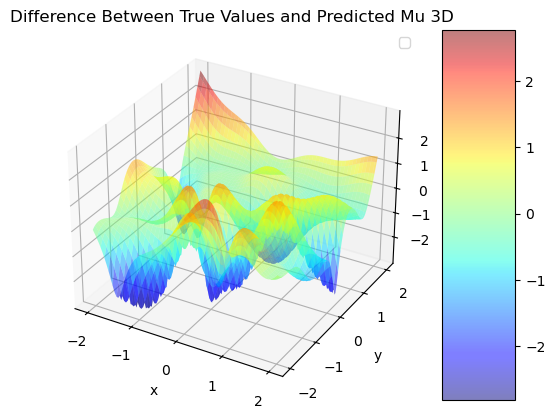

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


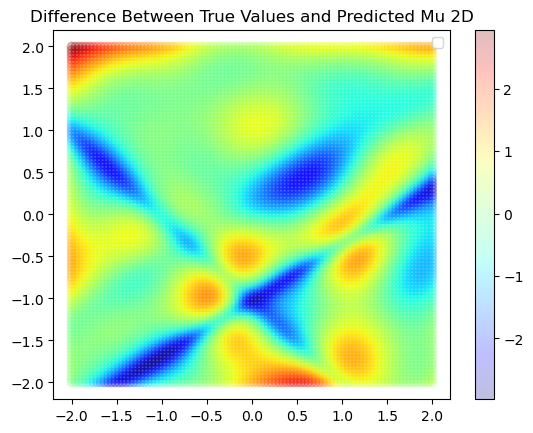

In [ ]:
##MEAN

data = Y_true_log - mu.reshape((len(X1), len(X2)))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X1, X2, data, cmap='jet', alpha = 0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.title('Difference Between True Values and Predicted Mu 3D')
fig.colorbar(surf, aspect=5)
plt.show()


fig = plt.figure()
plt.title('Difference Between True Values and Predicted Mu 2D')
plt.scatter(X1, X2, c=data, cmap='jet',vmin=data.min(), vmax=data.max(), alpha = 0.25)
plt.colorbar()
plt.legend()
plt.show()


##### STD

These STD values make sense. They are 0 where we have a data point and know the value with certainty. Additonally, they are higher where they are is more vairance in the function and where we have less data points sampled

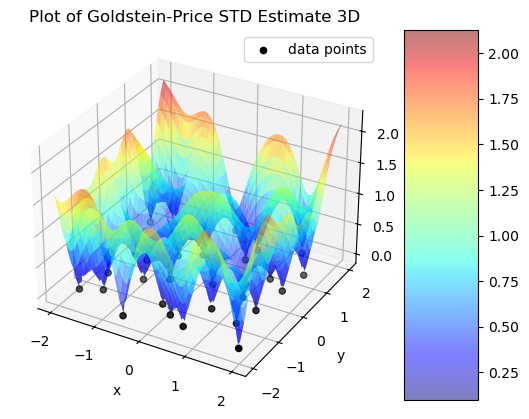

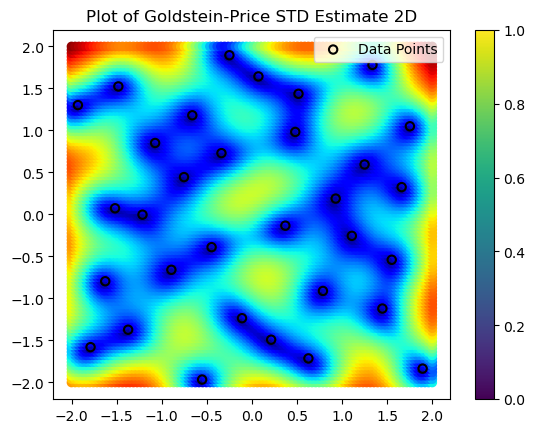

In [197]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X1, X2, std.reshape((len(X1), len(X2))), cmap='jet', alpha = 0.5)
ax.scatter(X_train[:,0], X_train[:,1],0, color = 'black', label = 'data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.title('Plot of Goldstein-Price STD Estimate 3D')
fig.colorbar(surf, aspect=5)
plt.show()


fig2 = plt.figure()
plt.title('Plot of Goldstein-Price STD Estimate 2D')
plt.scatter(X1, X2, c=std, cmap='jet',vmin=std.min(), vmax=std.max(), alpha = 1)
plt.scatter(X_train[:,0], X_train[:,1], color='black', label = 'Data Points', marker= MarkerStyle('o', fillstyle = 'none')  )
plt.colorbar()
plt.legend()
plt.show()


#### Z Scores 

This is good as it looks like a normal distribution

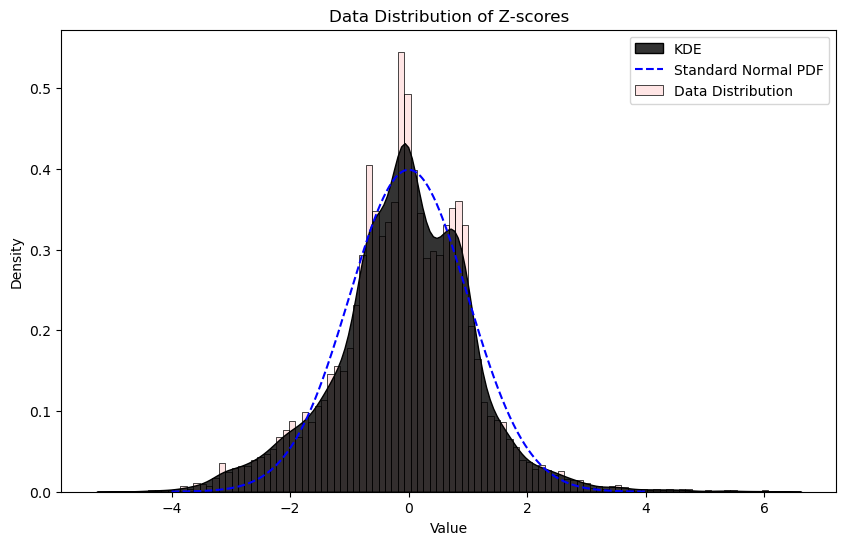

Z-Score Mean: -0.08, Standard Deviation: 1.16


In [ ]:
z_scores = ((Y_true_log - mu.reshape((len(X1), len(X2))))/ std.reshape((len(X1), len(X2)))).reshape(-1)

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution of Z-scores")

# Plot the histogram of the data (distribution)
x_plot = np.linspace(-4, 4, 500)
sns.histplot(z_scores, kde=False, bins=100, color='red', stat='density', alpha=0.1, label="Data Distribution")
sns.kdeplot(z_scores, fill=True, color='black', label='KDE',alpha=0.8)
plt.plot(x_plot, norm.pdf(x_plot), label="Standard Normal PDF", color="blue", linestyle="--")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()



z_mean = np.mean(z_scores)
z_std = np.std(z_scores)
print(f"Z-Score Mean: {z_mean:.2f}, Standard Deviation: {z_std:.2f}")

## BIC

In [217]:
BIC = np.asarray(3*math.log(len(X_train)) - 2* trace.log_likelihood.y_dist.mean())
f"BIC: {BIC}"


'BIC: 140.437223835401'

'BIC: -15.319168660305369'

#### BEST BIC (Compositional Kernel Grammar )

In [218]:
def fit_gp_model(X, y, mean_func, kernel_func, model_name=""):
      with pm.Model() as model:

            if mean_func == "constant":
                  m = pm.Normal(f"m{model_name}", 0, 5)
                  mean = pm.gp.mean.Constant(m)
            elif mean_func == "linear":
                  a1 = pm.Normal(f"a1{model_name}", 0, 5)
                  a2 = pm.Normal(f"a2{model_name}", 0, 5)
                  b = pm.Normal(f"b{model_name}", 0, 5)
                  mean = pm.gp.mean.Linear([a1,a2],b) 
            else:
                  raise ValueError("Unsupported Mean Functio")

            length = pm.Gamma(f"ℓ{model_name}", alpha=2, beta=1)
            output_scale = pm.HalfCauchy(f"η{model_name}", beta=1)
            
            if kernel_func == "RBF":
                  cov = output_scale**2 * pm.gp.cov.ExpQuad(2, ls=length)
            elif kernel_func == "Matern32":
                  cov = output_scale**2 * pm.gp.cov.Matern32(2, ls=length)
            elif kernel_func == "Matern52":
                  cov = output_scale**2 * pm.gp.cov.Matern52(2, ls=length)
            elif kernel_func == "Periodic":
                  p = pm.Gamma(f"p{model_name}", alpha=2, beta=1)
                  cov = output_scale**0.5 * pm.gp.cov.Periodic(2, ls=length, period=p)
            else:
                  raise ValueError("Unsupported kernel")

            σ = 0.001
            gp = pm.gp.Marginal(mean_func=mean, cov_func=cov)
            y_obs = gp.marginal_likelihood(f"y_obs{model_name}", X=X, y=y, sigma=σ)
            

            trace = pm.sample(progressbar=False)
            pm.compute_log_likelihood(trace)
            
      bic = np.asarray(3*math.log(len(X_train)) - 2* trace.log_likelihood[f"y_obs{model_name}"].mean())

      return bic, trace


mean_functions = ["constant", "linear"]
kernel_functions = ["RBF", "Matern32", "Matern52"]

best_bic = float('inf')
best_model = None


for mean_func in mean_functions:
    for kernel_func in kernel_functions:
        bic, trace = fit_gp_model(X_train, Y_train, mean_func, kernel_func, model_name=f"_{mean_func}_{kernel_func}")
        print(f"Model: Mean={mean_func}, Kernel={kernel_func}, BIC={bic:.2f}")
        

        if bic < best_bic:
            best_bic = bic
            best_model = (mean_func, kernel_func)

print(f"\nBest Model: Mean={best_model[0]}, Kernel={best_model[1]}, BIC={best_bic:.2f}")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_constant_RBF, ℓ_constant_RBF, η_constant_RBF]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Output()

Model: Mean=constant, Kernel=RBF, BIC=140.56


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_constant_Matern32, ℓ_constant_Matern32, η_constant_Matern32]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Output()

Model: Mean=constant, Kernel=Matern32, BIC=134.23


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_constant_Matern52, ℓ_constant_Matern52, η_constant_Matern52]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Output()

Model: Mean=constant, Kernel=Matern52, BIC=135.82


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1_linear_RBF, a2_linear_RBF, b_linear_RBF, ℓ_linear_RBF, η_linear_RBF]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Output()

Model: Mean=linear, Kernel=RBF, BIC=141.40


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1_linear_Matern32, a2_linear_Matern32, b_linear_Matern32, ℓ_linear_Matern32, η_linear_Matern32]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Output()

Model: Mean=linear, Kernel=Matern32, BIC=137.31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1_linear_Matern52, a2_linear_Matern52, b_linear_Matern52, ℓ_linear_Matern52, η_linear_Matern52]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Output()

Model: Mean=linear, Kernel=Matern52, BIC=138.05

Best Model: Mean=constant, Kernel=Matern32, BIC=134.23


## Bayesian Optimization